In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# For validation data

In [3]:
!unzip /content/drive/MyDrive/Dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9042.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9043.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9044.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9045.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9046.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9047.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9049.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9052.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9054.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9057.jpg  
  inflating: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9059.jpg  
  inflating: /content/Dataset/valida

In [4]:
# How many images in each folder
import os

# Walk through the data
for dirpath,dirnames,filenames in os.walk("Dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in Dataset.
There are 10 directories and 2 images in Dataset/training.
There are 3 directories and 0 images in Dataset/training/Erosion.
There are 0 directories and 2340 images in Dataset/training/Erosion/SEE-AI.
There are 0 directories and 354 images in Dataset/training/Erosion/KVASIR.
There are 0 directories and 0 images in Dataset/training/Erosion/KID.
There are 3 directories and 0 images in Dataset/training/Bleeding.
There are 0 directories and 519 images in Dataset/training/Bleeding/SEE-AI.
There are 0 directories and 312 images in Dataset/training/Bleeding/KVASIR.
There are 0 directories and 3 images in Dataset/training/Bleeding/KID.
There are 3 directories and 0 images in Dataset/training/Foreign Body.
There are 0 directories and 249 images in Dataset/training/Foreign Body/SEE-AI.
There are 0 directories and 543 images in Dataset/training/Foreign Body/KVASIR.
There are 0 directories and 0 images in Dataset/training/Foreign Body/KID.
There are

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras.utils import Sequence

class BalancedImageDataGenerator:
    def __init__(self, target_samples=5000, balance_classes=True, **kwargs):
        self.target_samples = target_samples
        self.balance_classes = balance_classes
        self.image_data_generator = ImageDataGenerator(**kwargs)

    def flow_from_directory(self, directory, shuffle=True, **kwargs):
        # First, get the base generator
        base_generator = self.image_data_generator.flow_from_directory(
            directory,
            shuffle=False,  # We'll handle shuffling ourselves
            **kwargs
        )

        # Get all filenames and their corresponding labels
        filenames = base_generator.filenames
        labels = base_generator.classes
        class_indices = base_generator.class_indices
        n_classes = len(class_indices)

        if not self.balance_classes:
            # If not balancing, just use original filenames and labels
            balanced_filenames = filenames
            balanced_labels = labels
        else:
            # Create balanced dataset
            balanced_filenames = []
            balanced_labels = []

            # Count samples per class
            class_counts = Counter(labels)

            for class_idx in range(n_classes):
                class_files = [f for f, l in zip(filenames, labels) if l == class_idx]
                class_count = len(class_files)

                if class_count >= self.target_samples:
                    # Undersample
                    selected_files = shuffle(class_files)[:self.target_samples] if shuffle else class_files[:self.target_samples]
                else:
                    # Oversample
                    multiplier = self.target_samples // class_count
                    remainder = self.target_samples % class_count
                    if shuffle:
                        selected_files = class_files * multiplier + shuffle(class_files)[:remainder]
                    else:
                        selected_files = class_files * multiplier + class_files[:remainder]

                balanced_filenames.extend(selected_files)
                balanced_labels.extend([class_idx] * len(selected_files))

        # Shuffle the dataset if requested
        if shuffle:
            balanced_filenames, balanced_labels = shuffle(balanced_filenames, balanced_labels)

        class DataGenerator(Sequence):
            def __init__(self, parent, filenames, labels, directory, shuffle=True, **kwargs):
                self.parent = parent
                self.filenames = filenames
                self.labels = labels
                self.directory = directory
                self.n = len(filenames)
                self.batch_size = kwargs.get('batch_size', 32)
                self.target_size = kwargs.get('target_size', (224, 224))
                self.shuffle = shuffle
                self.indices = np.arange(self.n)
                self.class_indices = class_indices

                if self.shuffle:
                    np.random.shuffle(self.indices)

            def __len__(self):
                return int(np.ceil(self.n / float(self.batch_size)))

            def __getitem__(self, idx):
                start_idx = idx * self.batch_size
                end_idx = min((idx + 1) * self.batch_size, self.n)
                batch_indices = self.indices[start_idx:end_idx]

                batch_files = [os.path.join(self.directory, self.filenames[i]) for i in batch_indices]
                batch_labels = [self.labels[i] for i in batch_indices]
                batch_image_names = [os.path.basename(self.filenames[i]) for i in batch_indices]

                # Load and preprocess images
                batch_images = []
                for f in batch_files:
                    # Load image
                    img = tf.keras.utils.load_img(f, target_size=self.target_size)
                    # Convert to array
                    img_array = tf.keras.utils.img_to_array(img)
                    # Apply standardization
                    img_array = self.parent.image_data_generator.standardize(img_array)
                    # Apply random transformations
                    img_array = self.parent.image_data_generator.random_transform(img_array)
                    batch_images.append(img_array)

                batch_images = np.array(batch_images)

                # Convert labels to categorical
                batch_labels = tf.keras.utils.to_categorical(batch_labels, n_classes)

                return batch_images, batch_labels, np.array(batch_image_names)

            def on_epoch_end(self):
                if self.shuffle:
                    np.random.shuffle(self.indices)

        return DataGenerator(self, balanced_filenames, balanced_labels, directory, shuffle=shuffle, **kwargs)

In [6]:
# Validation generator without balancing
val_datagen = BalancedImageDataGenerator(
    balance_classes=False,  # Disable balancing for validation
    rescale=1./255
)

In [7]:
val_dir = "/content/Dataset/validation"

In [8]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    shuffle=False,
    batch_size=32,
    class_mode='categorical'
)

Found 16132 images belonging to 10 classes.


In [6]:
!unzip /content/drive/MyDrive/resnet_modified_Kaist-20241023T182201Z-001.zip -d /content/

Archive:  /content/drive/MyDrive/resnet_modified_Kaist-20241023T182201Z-001.zip
   creating: /content/resnet_modified_Kaist/assets/
  inflating: /content/resnet_modified_Kaist/fingerprint.pb  
  inflating: /content/resnet_modified_Kaist/variables/variables.index  
  inflating: /content/resnet_modified_Kaist/saved_model.pb  
  inflating: /content/resnet_modified_Kaist/variables/variables.data-00000-of-00001  


In [7]:
base_model = tf.keras.layers.TFSMLayer('/content/resnet_modified_Kaist', call_endpoint='serving_default')
inputs = tf.keras.Input(shape=(224, 224, 3))  # Set the correct input shape
outputs = base_model(inputs)  # o is your TFSMLayer
resnet_model = tf.keras.Model(inputs, outputs)

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import json
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score

def save_predictions_to_excel(image_paths, y_pred, output_path):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    df_merged.to_excel(output_path, index=False)


def calculate_specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

def generate_metrics_report(y_true, y_pred):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}

    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)

    auc_roc_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            auc_roc_scores[class_name] = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            auc_roc_scores[class_name] = 0.0

    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    auc_roc_scores['mean_auc'] = mean_auc_roc

    specificity_scores = {}
    for i, class_name in enumerate(class_columns):
        specificity_scores[class_name] = calculate_specificity(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int))  # Thresholding y_pred

    mean_specificity = np.mean(list(specificity_scores.values()))
    specificity_scores['mean_specificity'] = mean_specificity

    average_precision_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            average_precision_scores[class_name] = auc(recall, precision)
        except ValueError:
            average_precision_scores[class_name] = 0.0

    mean_average_precision = np.mean(list(average_precision_scores.values()))
    average_precision_scores['mean_average_precision'] = mean_average_precision

    sensitivity_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            sensitivity_scores[class_name] = recall_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            sensitivity_scores[class_name] = 0.0

    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    sensitivity_scores['mean_sensitivity'] = mean_sensitivity

    f1_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            f1_scores[class_name] = f1_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            f1_scores[class_name] = 0.0

    mean_f1_score = np.mean(list(f1_scores.values()))
    f1_scores['mean_f1_score'] = mean_f1_score
    balanced_accuracy_scores = balanced_accuracy_score(y_true_classes, y_pred_classes)

    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy_scores

    metrics_report_json = json.dumps(metrics_report, indent=4)
    return metrics_report_json




In [12]:
len(validation_generator)

505

Total number of batches: 505
Processing batch 0/505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/ste

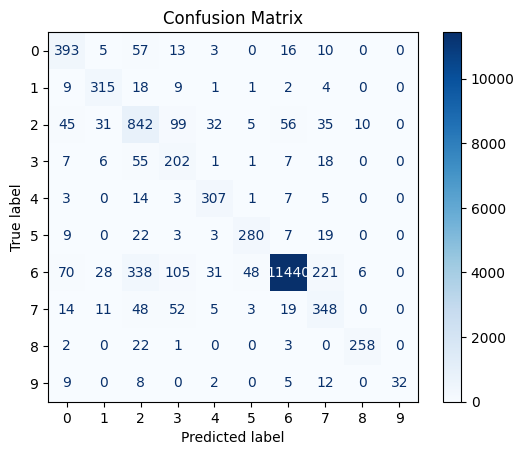

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, f1_score

# Calculate total number of batches from the generator
total_batches = len(validation_generator)
print(f"Total number of batches: {total_batches}")

# Step 1: Generate predictions for all batches
val_pred = []
val_true = []
val_predictions = []
val_true_classes = []
val_image_names = []

for i, (x, y, img_names) in enumerate(validation_generator):
    if i % 50 == 0:  # Print progress every 50 batches
        print(f"Processing batch {i}/{total_batches}")

    preds = resnet_model.predict(x)
    val_pred.append(preds['output_0'])
    val_predictions.append(np.argmax(preds['output_0'], axis=1))
    val_true.append(y)
    val_true_classes.append(np.argmax(y, axis=1))
    val_image_names.append(img_names)

    if i >= total_batches - 1:
        break

# Step 2: Concatenate predictions, true labels, and image names across batches
val_pred_concateneated = np.concatenate(val_pred)
val_true = np.concatenate(val_true)
val_pred_classes = np.concatenate(val_predictions)
val_true_classes = np.concatenate(val_true_classes)
val_image_names = np.concatenate(val_image_names)

print("\nFinal shapes:",
      "\nTrue classes:", val_true_classes.shape,
      "\nPredicted classes:", val_pred_classes.shape,
      "\nImage names:", val_image_names.shape,
      "\nVal true:", val_true.shape,
      "\nVal_pred_concatenated:", val_pred_concateneated.shape)

# Create a results dictionary mapping image names to their predictions and true labels
results = {
    'image_names': val_image_names,
    'true_classes': val_true_classes,
    'predicted_classes': val_pred_classes
}

# Create a DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame({
    'image_name': val_image_names,
    'true_class': val_true_classes,
    'predicted_class': val_pred_classes,
    'correct_prediction': val_true_classes == val_pred_classes
})

# Print some example results
print("\nExample results:")
print(results_df.head())

# Calculate metrics
balanced_acc = balanced_accuracy_score(val_true_classes, val_pred_classes)
f1 = f1_score(val_true_classes, val_pred_classes, average='weighted')

print(f"\nBalanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(val_true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Save results to CSV
results_df.to_csv('validation_results.csv', index=False)

In [19]:
generate_metrics_report(val_true,val_pred_concateneated)

'{\n    "Angioectasia": {\n        "precision": 0.7005347593582888,\n        "recall": 0.7907444668008048,\n        "f1-score": 0.7429111531190926,\n        "support": 497.0\n    },\n    "Bleeding": {\n        "precision": 0.7954545454545454,\n        "recall": 0.8774373259052924,\n        "f1-score": 0.8344370860927153,\n        "support": 359.0\n    },\n    "Erosion": {\n        "precision": 0.5912921348314607,\n        "recall": 0.729004329004329,\n        "f1-score": 0.6529662659945715,\n        "support": 1155.0\n    },\n    "Erythema": {\n        "precision": 0.41478439425051333,\n        "recall": 0.6801346801346801,\n        "f1-score": 0.5153061224489796,\n        "support": 297.0\n    },\n    "Foreign Body": {\n        "precision": 0.7974025974025974,\n        "recall": 0.9029411764705882,\n        "f1-score": 0.8468965517241379,\n        "support": 340.0\n    },\n    "Lymphangiectasia": {\n        "precision": 0.8259587020648967,\n        "recall": 0.8163265306122449,\n     

In [11]:
def save_predictions_to_excel(image_paths, y_pred, output_path):
    # Ensure output path has .xlsx extension
    if not output_path.endswith('.xlsx'):
        output_path = output_path + '.xlsx'

    # Define class columns
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body',
                    'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

    # Convert image_paths to list if it's numpy array
    image_paths = image_paths.tolist() if isinstance(image_paths, np.ndarray) else image_paths

    # Get predicted class indices
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get predicted class names
    predicted_class_names = [class_columns[i] for i in y_pred_classes]

    # Create DataFrame with probabilities
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)

    # Create DataFrame with predicted classes
    df_class = pd.DataFrame({
        'image_path': image_paths,
        'predicted_class': predicted_class_names
    })

    # Merge DataFrames
    df_merged = pd.merge(df_prob, df_class, on='image_path')

    try:
        # Save to Excel
        df_merged.to_excel(output_path, index=False)
        print(f"Successfully saved predictions to {output_path}")
        print(f"Total images processed: {len(image_paths)}")
        print(f"Shape of final DataFrame: {df_merged.shape}")
    except Exception as e:
        print(f"Error saving to Excel: {str(e)}")

    return df_merged  # Return DataFrame for additional processing if needed

In [12]:
# For .xlsx files
!pip install openpyxl

# Or for .xls files
!pip install xlwt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 8.9 MB/s eta 0:00:00


In [24]:
save_predictions_to_excel(val_image_names, val_pred_concateneated, "/content/predicted_classes.xlsx")

Successfully saved predictions to /content/predicted_classes.xlsx
Total images processed: 16132
Shape of final DataFrame: (16224, 12)


,image_path,Angioectasia,Bleeding,Erosion,Erythema,Foreign Body,Lymphangiectasia,Normal,Polyp,Ulcer,Worms,predicted_class
0,angioectasia-P0-3.jpg,0.044846,0.000182,0.005838,6.561823e-05,5.042241e-06,1.864918e-04,0.948589,0.000257,1.922879e-05,1.217836e-05,Normal
1,angioectasia-P0-4.jpg,0.998255,0.000040,0.000821,3.255414e-07,3.865655e-06,4.139875e-05,0.000736,0.000038,5.479596e-05,1.006845e-05,Angioectasia
2,angioectasia-P0-6.jpg,0.999911,0.000006,0.000054,4.374444e-08,7.589344e-09,7.118808e-07,0.000008,0.000019,1.023167e-07,1.735464e-07,Angioectasia
3,angioectasia-P1-4.jpg,0.981296,0.016100,0.002007,5.760802e-06,1.270016e-06,1.525263e-04,0.000090,0.000244,8.416831e-05,1.915993e-05,Angioectasia
4,angioectasia-P1-5.jpg,0.998730,0.000141,0.000096,2.020310e-06,4.928282e-07,2.804406e-05,0.000033,0.000963,1.666720e-06,5.290985e-06,Angioectasia
...,...,...,...,...,...,...,...,...,...,...,...,...
16219,worm3_306.jpg,0.016028,0.000604,0.531476,9.868261e-03,1.062815e-02,3.451015e-03,0.076360,0.266910,5.123289e-04,8.416118e-02,Erosion
16220,worm3_316.jpg,0.005373,0.000012,0.034524,6.438547e-05,7.444608e-05,6.037035e-04,0.002507,0.131984,3.056456e-05,8.248263e-01,Worms
16221,worm3_366.jpg,0.008797,0.000415,0.030423,2.701446e-04,1.996017e-03,7.571884e-03,0.007361,0.024113,6.903176e-04,9.183639e-01,Worms
16222,worm3_396.jpg,0.006735,0.000118,0.826242,2.688896e-03,2.243843e-04,5.852102e-04,0.012651,0.147377,7.670512e-05,3.301319e-03,Erosion


# For testing data


In [3]:
!unzip "/content/drive/MyDrive/Testing set.zip" -d /content/

Archive:  /content/drive/MyDrive/Testing set.zip
   creating: /content/Testing set/
   creating: /content/Testing set/Images/
  inflating: /content/Testing set/Images/00Z0Xo99wp.jpg  
  inflating: /content/Testing set/Images/02hvtCoV9C.jpg  
  inflating: /content/Testing set/Images/03pjR51twC.jpg  
  inflating: /content/Testing set/Images/03UqLvuk8v.jpg  
  inflating: /content/Testing set/Images/04jiugLcCI.jpg  
  inflating: /content/Testing set/Images/04tn1G74xo.jpg  
  inflating: /content/Testing set/Images/05c6TBcXSu.jpg  
  inflating: /content/Testing set/Images/06fIH8amoG.jpg  
  inflating: /content/Testing set/Images/06XFjXueSX.jpg  
  inflating: /content/Testing set/Images/07jOML1ogZ.jpg  
  inflating: /content/Testing set/Images/07nd6BLrq1.jpg  
  inflating: /content/Testing set/Images/07rfIWuhqW.jpg  
  inflating: /content/Testing set/Images/08EWI6eGVX.jpg  
  inflating: /content/Testing set/Images/09LTohVSRn.jpg  
  inflating: /content/Testing set/Images/0a0lZMebPu.jpg  
  in

In [8]:
# Validation generator without balancing
test_datagen = BalancedImageDataGenerator(
    balance_classes=False,  # Disable balancing for validation
    rescale=1./255
)

In [9]:
test_dir = "/content/Testing set"
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    shuffle=False,
    batch_size=32,
    class_mode='categorical'
)

Found 4385 images belonging to 1 classes.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, f1_score

# Calculate total number of batches from the generator
total_batches = len(test_generator)
print(f"Total number of batches: {total_batches}")

# Step 1: Generate predictions for all batches
test_pred = []
test_true = []
test_predictions = []
test_true_classes = []
test_image_names = []

for i, (x, y, img_names) in enumerate(test_generator):
    if i % 50 == 0:  # Print progress every 50 batches
        print(f"Processing batch {i}/{total_batches}")

    preds = resnet_model.predict(x)
    test_pred.append(preds['output_0'])
    test_predictions.append(np.argmax(preds['output_0'], axis=1))
    # test_true.append(y)
    # test_true_classes.append(np.argmax(y, axis=1))
    test_image_names.append(img_names)

    if i >= total_batches - 1:
        break

# Step 2: Concatenate predictions, true labels, and image names across batches
test_pred_concateneated = np.concatenate(test_pred)
# test_true = np.concatenate(test_true)
test_pred_classes = np.concatenate(test_predictions)
# test_true_classes = np.concatenate(test_true_classes)
test_image_names = np.concatenate(test_image_names)

print("\nFinal shapes:",
      # "\nTrue classes:", test_true_classes.shape,
      "\nPredicted classes:", test_pred_classes.shape,
      "\nImage names:",test_image_names.shape,
      # "\nTest true:", test_true.shape,
      "\nTest_pred_concatenated:", test_pred_concateneated.shape)

# Create a results dictionary mapping image names to their predictions and true labels
# results = {
#     'image_names': test_image_names,
#     'true_classes': test_true_classes,
#     'predicted_classes': test_pred_classes
# }

# Create a DataFrame for easier analysis
# import pandas as pd
# results_df = pd.DataFrame({
#     'image_name': val_image_names,
#     'true_class': val_true_classes,
#     'predicted_class': val_pred_classes,
#     'correct_prediction': val_true_classes == val_pred_classes
# })

# # Print some example results
# print("\nExample results:")
# print(results_df.head())

# # Calculate metrics
# balanced_acc = balanced_accuracy_score(val_true_classes, val_pred_classes)
# f1 = f1_score(val_true_classes, val_pred_classes, average='weighted')

# print(f"\nBalanced Accuracy: {balanced_acc:.4f}")
# print(f"F1 Score: {f1:.4f}")

# # Create confusion matrix
# cm = confusion_matrix(val_true_classes, val_pred_classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.show()

# # Save results to CSV
# results_df.to_csv('validation_results.csv', index=False)

Total number of batches: 138
Processing batch 0/138
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [15]:
save_predictions_to_excel(test_image_names, test_pred_concateneated, "/content/predicted_classes_test.xlsx")